In [1]:
import autograd 

import autograd.numpy as np
import autograd.scipy as sp
from numpy.polynomial.hermite import hermgauss

import sys
sys.path.insert(0, '../libraries/')
sys.path.insert(0, '../../BNP_modeling/')

import structure_model_lib 
import modeling_lib
import data_utils
import cluster_quantities_lib

import paragami

import matplotlib.pyplot as plt
%matplotlib inline  


In [2]:
np.random.seed(534534)

# Draw data

In [3]:
n_obs = 160
n_loci = 5
n_pop = 4

# population allele frequencies
p1 = 0.99
p0 = 0.01
true_pop_allele_freq = np.maximum(np.eye(n_loci, n_pop) * p1, p0)

# individual admixtures
scale = 10
true_ind_admix_propn = np.random.choice(n_pop, n_obs)
true_ind_admix_propn = scale * data_utils.get_one_hot(true_ind_admix_propn, nb_classes = n_pop)
true_ind_admix_propn = np.exp(true_ind_admix_propn) / np.exp(true_ind_admix_propn).sum(axis = 1, keepdims=True)

In [4]:
clustering_indx = data_utils.cluster_admix_get_indx(true_ind_admix_propn)
true_ind_admix_propn = true_ind_admix_propn[clustering_indx, :]

In [5]:
print(true_pop_allele_freq)

[[0.99 0.01 0.01 0.01]
 [0.01 0.99 0.01 0.01]
 [0.01 0.01 0.99 0.01]
 [0.01 0.01 0.01 0.99]
 [0.01 0.01 0.01 0.01]]


In [6]:
true_ind_admix_propn[0:5, :]

array([[4.53937471e-05, 4.53937471e-05, 9.99863819e-01, 4.53937471e-05],
       [4.53937471e-05, 4.53937471e-05, 9.99863819e-01, 4.53937471e-05],
       [4.53937471e-05, 4.53937471e-05, 9.99863819e-01, 4.53937471e-05],
       [4.53937471e-05, 4.53937471e-05, 9.99863819e-01, 4.53937471e-05],
       [4.53937471e-05, 4.53937471e-05, 9.99863819e-01, 4.53937471e-05]])

In [7]:
g_obs = data_utils.draw_data(true_pop_allele_freq, true_ind_admix_propn)

In [8]:
k_approx = n_pop

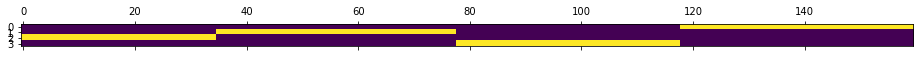

In [9]:
plt.matshow(true_ind_admix_propn.T)

# Get init

In [10]:
init_ind_admix_propn, init_pop_allele_freq = structure_model_lib.cluster_and_get_init(g_obs, k_approx)

In [11]:
perm = data_utils.find_min_perm(init_pop_allele_freq, true_pop_allele_freq, axis = 1)
init_pop_allele_freq = init_pop_allele_freq[:, perm]
init_ind_admix_propn = init_ind_admix_propn[:, perm]

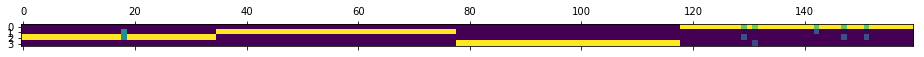

In [12]:
plt.matshow(init_ind_admix_propn.T)

In [13]:
assert np.all(np.abs(init_ind_admix_propn.sum(axis = 1) - 1) < 1e-12)

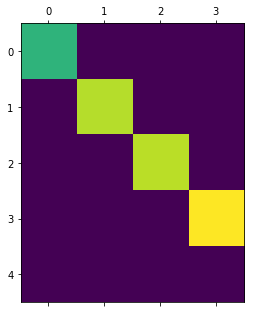

In [14]:
plt.matshow(init_pop_allele_freq)

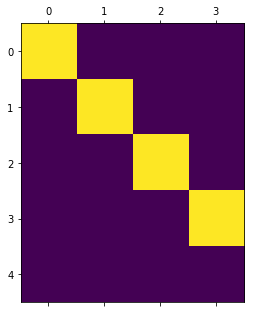

In [15]:
plt.matshow(true_pop_allele_freq)

# Convert init to VB params

In [16]:
# check function to get stick breaking proportions 
stick_break_propn = \
    cluster_quantities_lib.get_stick_break_propns_from_mixture_weights(init_ind_admix_propn)

In [17]:
mixture_weights = cluster_quantities_lib.get_mixture_weights_from_stick_break_propns(stick_break_propn)
assert np.all(np.abs(mixture_weights - init_ind_admix_propn) < 1e-12)

In [18]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

vb_params_dict, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs, n_loci, k_approx)
    
print(vb_params_paragami)

OrderedDict:
	[pop_freq_beta_params] = NumericArrayPattern (5, 4, 2) (lb=0.0, ub=inf)
	[ind_mix_stick_propn_mean] = NumericArrayPattern (160, 3) (lb=-inf, ub=inf)
	[ind_mix_stick_propn_info] = NumericArrayPattern (160, 3) (lb=0.0001, ub=inf)


In [19]:
vb_params_dict = structure_model_lib.set_init_vb_params(g_obs, k_approx, vb_params_dict)

In [21]:
# check vb means 
e_ind_admix = cluster_quantities_lib.get_e_cluster_probabilities(
                    vb_params_dict['ind_mix_stick_propn_mean'], 
                    vb_params_dict['ind_mix_stick_propn_info'],
                    gh_loc, gh_weights)

e_pop_freq = modeling_lib.get_e_beta(vb_params_dict['pop_freq_beta_params'])

In [22]:
perm = data_utils.find_min_perm(e_pop_freq, true_pop_allele_freq, axis = 1)

e_pop_freq = e_pop_freq[:, perm]
e_ind_admix = e_ind_admix[:, perm]

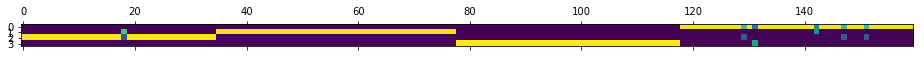

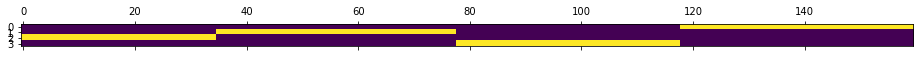

In [23]:
plt.matshow(e_ind_admix.T); 
plt.matshow(true_ind_admix_propn.T);

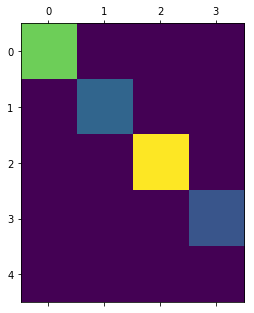

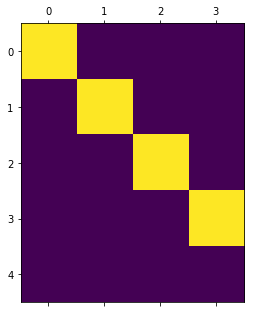

In [24]:
plt.matshow(e_pop_freq); 
plt.matshow(true_pop_allele_freq);